In [1]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
import os
import xmltodict
from torch.utils.data import Dataset
from PIL import Image

class VOCDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.labels = self.load_labels()
        self.images = self.load_all_images()

    def load_labels(self):
        labels = []
        with open(os.path.join(self.data_dir, 'voc.names'), 'r') as f:
            labels = f.read().strip().split('\n')
        return labels

    def load_all_images(self):
        image_list = []
        image_dir = os.path.join(self.data_dir, 'JPEGImages')
        for filename in os.listdir(image_dir):
            if filename.endswith('.jpg'):
                image_list.append(os.path.splitext(filename)[0])  # Añadir nombre de archivo sin extensión
        return image_list

    def parse_voc_annotation(self, annotation_file):
        with open(annotation_file, 'r') as f:
            xml_data = xmltodict.parse(f.read())
        objects = xml_data['annotation']['object']
        if not isinstance(objects, list):
            objects = [objects]
        annotations = []
        for obj in objects:
            label = obj['name']
            bbox = obj['bndbox']
            xmin, ymin, xmax, ymax = int(bbox['xmin']), int(bbox['ymin']), int(bbox['xmax']), int(bbox['ymax'])
            annotations.append((xmin, ymin, xmax, ymax, self.labels.index(label)))
        return annotations

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, 'JPEGImages', self.images[idx] + '.jpg')
        annotation_path = os.path.join(self.data_dir, 'Annotations', self.images[idx] + '.xml')
        image = Image.open(image_path).convert('RGB')
        annotations = self.parse_voc_annotation(annotation_path)

        if self.transform:
            image = self.transform(image)

        return image, annotations

In [3]:
from torchvision import transforms

data_transforms = transforms.Compose([
    transforms.Resize((800, 600)),
    transforms.ToTensor()
])

data_dir = './Camerav4ivoc/train/'
dataset = VOCDataset(data_dir, transform=data_transforms)

# Para acceder a un ejemplo del conjunto de datos
image, annotations = dataset[0]
print("Image shape:", image.shape)
print("Annotations:", annotations)

classes = ["camera", "router", "car"]
train = dataset

Image shape: torch.Size([3, 800, 600])
Annotations: [(105, 192, 459, 571, 0)]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects

def get_sample(ix):
    img, labels = train[ix]
    img_np = np.array(img)
    
    # Suponiendo que las coordenadas del cuadro delimitador y la etiqueta están en una tupla en labels
    bbs = np.array([[int(xmin), int(ymin), int(xmax), int(ymax)] for xmin, ymin, xmax, ymax, _ in labels])
    labels = np.array([int(etiqueta) for _, _, _, _, etiqueta in labels])
    
    anns = (labels, bbs)
    return img_np, anns

def plot_anns(img, anns, ax=None, bg=-1, img_shape=(800, 600, 3), classes=classes):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        
    img = np.transpose(img, (1, 2, 0))
    ax.imshow(img.reshape(img_shape))
    
    labels, bbs = anns
    for lab, bb in zip(labels, bbs):
        if bg == -1 or lab != bg:
            x, y, xm, ym = bb
            w, h = xm - x, ym - y
            rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
            text = ax.text(x, y - 10, classes[lab], color='red', fontsize=10, ha='left')
            text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='white')]) #type: ignore
            ax.add_patch(rect)

In [5]:
img_np, anns = get_sample(0)
img_np.shape, anns

((3, 800, 600), (array([0]), array([[105, 192, 459, 571]])))

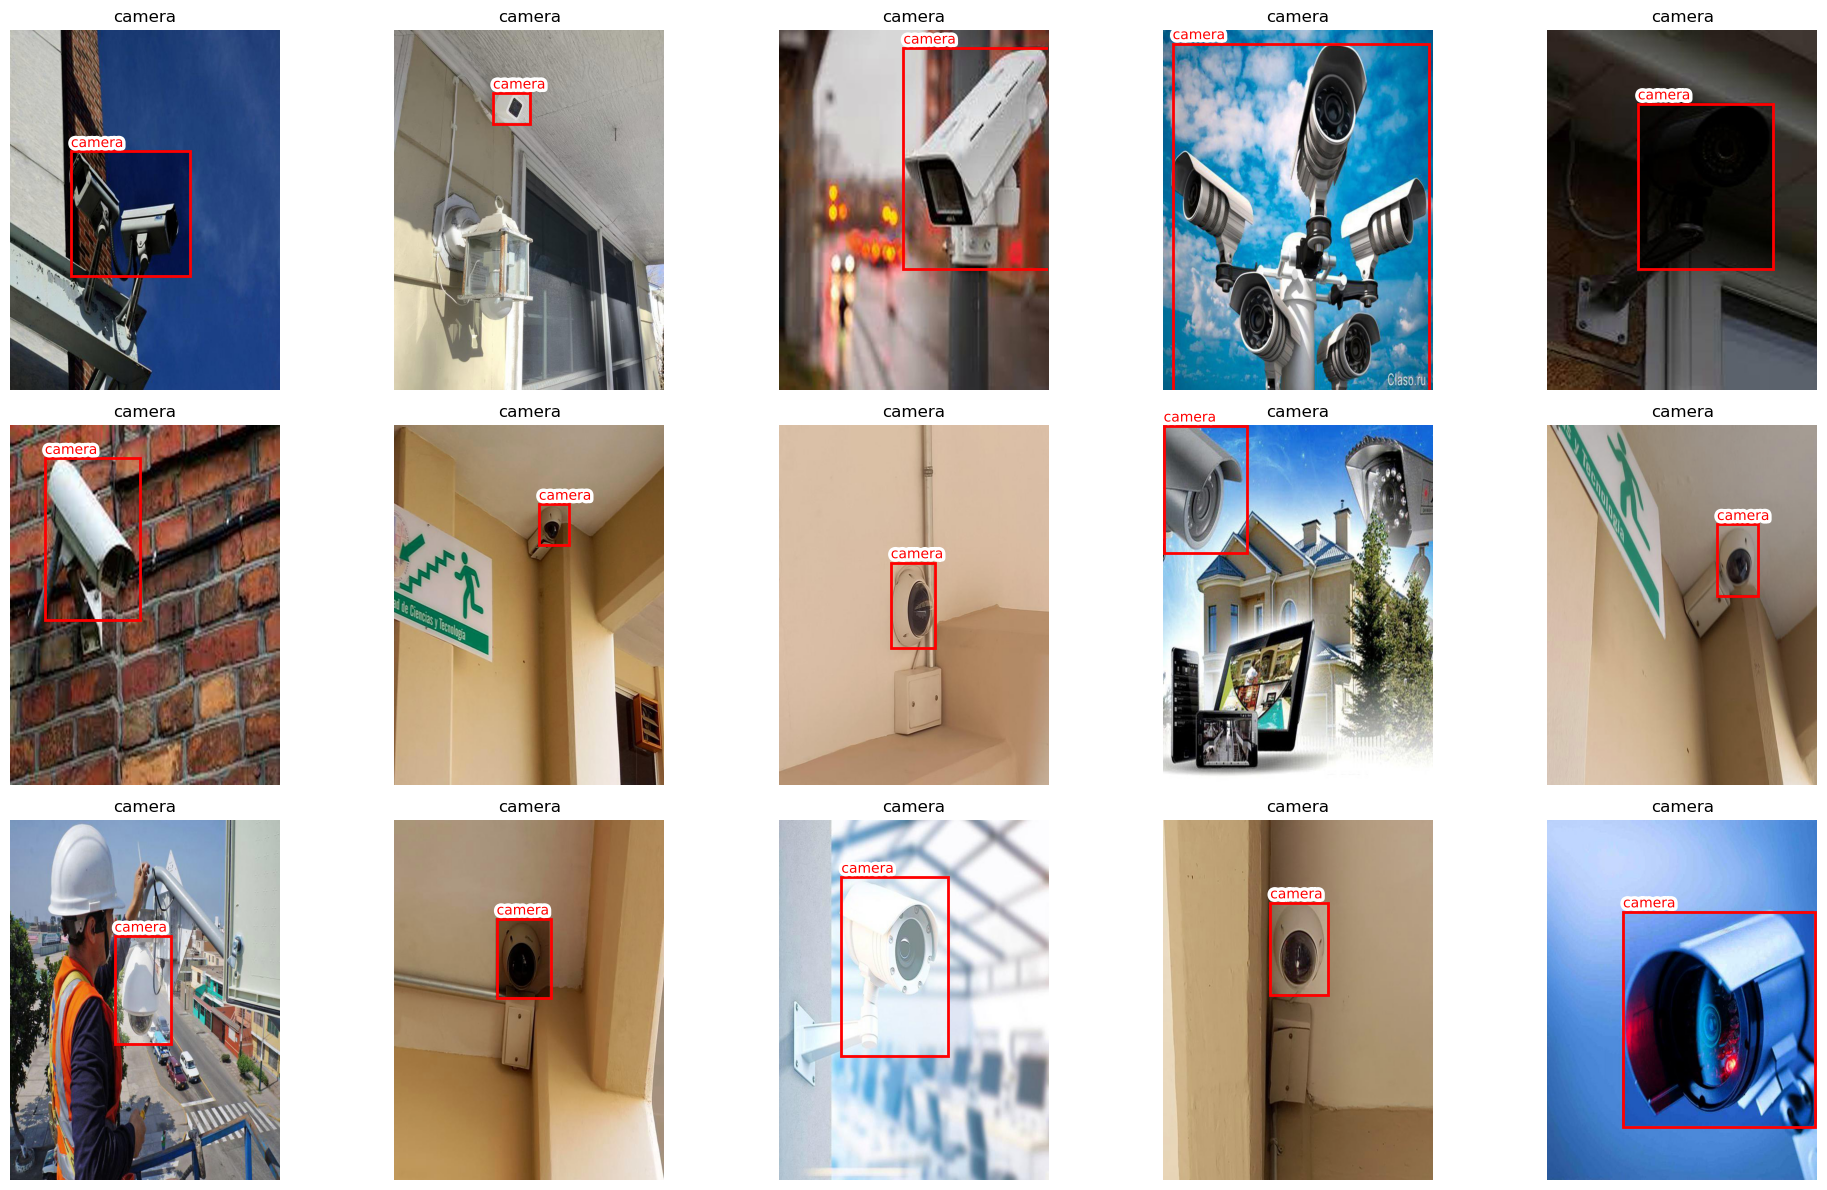

In [6]:
import random

r, c = 3, 5
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(train)-1)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        ax.set_title(classes[anns[0][0]])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
import torch
from torchvision.models.detection import retinanet_resnet50_fpn

# Cargar un modelo preentrenado
model = retinanet_resnet50_fpn(pretrained=True)

# Modificar la última capa para el número de clases en tu conjunto de datos
num_classes = 3  # Reemplaza con el número de clases en tu conjunto de datos
# Obtener el número de características de entrada para la nueva capa lineal
in_features = model.head.classification_head.cls_logits.weight.shape[1]
# Crear una nueva capa lineal con el número de clases de salida
model.head.classification_head.cls_logits = torch.nn.Linear(in_features, num_classes)

Image shape: (3, 800, 600)


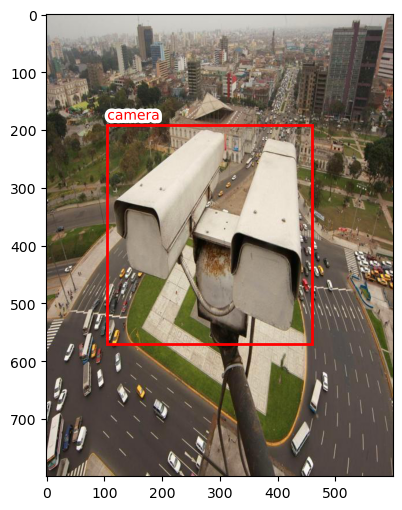

In [9]:
img_np, anns = get_sample(0)
print("Image shape:", img_np.shape)
plot_anns(img_np, anns)
plt.show()

In [10]:
# Define la función de pérdida focal
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = torch.nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [13]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True, num_workers=4)

In [14]:
import torch.optim as optim

# Configurar el optimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = model.to(device)
criterion = FocalLoss()

# Número de épocas de entrenamiento
num_epochs = 2

# Bucle de entrenamiento
for epoch in range(num_epochs):
    total_loss = 0.0  # Inicializar la pérdida total del epoch
    for images, targets in train_dataloader:
        images = list(image.to(device) for image in images)  # Mover imágenes a la GPU
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Mover etiquetas a la GPU
        
        # Forward y cálculo de pérdida
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()  # Sumar la pérdida para este lote
        
        # Optimización
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        print('.', end='')
    
    # Calcular el promedio de la pérdida para el epoch actual
    avg_loss = total_loss / len(train_dataloader)
    
    # Imprimir la pérdida
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')